The aim of this analysis is to compare customer spending behaviour in stores with smart fitting room technology vs stores without. The aim is to answer the following question:

**Which items from different departments are frequently bought together?**

If stores can have the answer to this question, then it may affect how they position merchandise in the store.

For this analysis, there are a few things to note:

1. I will be focusing on customer activity in 4 week period in autumn. This avoids peak sale periods. 
2. Only the womenswear division will be focused on as the majority of sales are from Womenswear.
3. Not all departments within womenswear were selected. Only the departments which formed 93% of the sales in the past year were analysed. 
4. All data imported was pulled from tables in Snowflake.

# Explanation of metrics below:

These metrics are commonly used in basket analysis:

1. **Antecedent Support**: the proportion of data attributed to this department.

2. **Consequent Support**: the proportion of data attributed to this department.

3. **Support**:  the frequency at which the antecendent and consequent (itemset) appear together in the data i.e. how often this particular itemset occue in the data. Support is calculated by dividing the number of transactions containing an item set by the total number of transactions. Support [0,1]. 

4. **Confidence**: the probability of seeing the consequent in a transaction given that it also contains the antecedent. Note that you cannot assume that it's the same the other way e.g if a --> b = 0.8, b --> a is not necessarily 0.8. Confidence [0,1].

5. **Lift**: a measure of how much more often the antecedent and consequent of a rule A-->C occur together than we would expect if they were statistically independent. If A and C are independent, the Lift score will be exactly 1. Lift < 1 means that they are less likely to be bought together. Lift [0, ∞].

6. **Leverage**: Leverage computes the difference between the observed frequency of A and C appearing together and the frequency that would be expected if A and C were independent. A leverage value of 0 indicates independence. Leverage [-1,1].

7. **Conviction**: a measure of how dependent the consequent is on the antecedent. The higher conviction, the more dependent the consequent is on the antecedent and vice versa. If items are independent, the conviction is 1. Conviction [0, ∞]

8. **Zhangs Metric**: Used to measure association and dissociation. A positive value (>0) indicates Association and negative value indicated dissociation. Range [-1,1]

# Importing the relevant libraries and data

Importing relevant libraries for this analysis. 

In [1]:
#These libraries are for the manipulation and organisation of data frames

import pandas as pd
import numpy as np

#These libraries are for the actual basket analysis

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#These libraries are for presenting the metrics from the basket analysis in a easy to digest way for stakeholders

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#I might need this, but I'm not sure yet. 
import re

# Part 1: Conducting Basket Analysis on Stores with Smart Fitting Rooms (Visits)

This first portion of the analysis answers the question **What do customers frequently take into the fitting room? (regardless of a sale)**

Importing the CSV and turning it into a dataframe.

In [2]:
df = pd.read_csv('Crave Basket FRV.csv')
df.head()

,TERRITORY,MARKET,LOCATION_ID,LOCATION_DESCR,CAL_DT,MERCH_YR_WK,UNIQUE_SHOPPER_ID,DEPT_DESCR,ITEM_QUANTITY,ITEM_PRICE
0,SOUTH,SOUTH EAST,22,KINGSTON,08/10/2023,202341,1263495,Cottons,1,30.0
1,SOUTH,SOUTH EAST,22,KINGSTON,08/10/2023,202341,1263495,Knitwear,2,74.0
2,SOUTH,SOUTH EAST,22,KINGSTON,08/10/2023,202341,1263500,Denim,1,48.0
3,SOUTH,SOUTH EAST,22,KINGSTON,08/10/2023,202341,1263500,Knitwear,3,98.0
4,SOUTH,SOUTH EAST,22,KINGSTON,08/10/2023,202341,1263545,Dresses and All in 1s,1,60.0


For the analysis, we need quantities to be 1s or 0s. Everywhere that's 0 will remain as 0 and everywhere that's 1 or more will be set to 1. Remember, we're not interested in how many items belonging to the same departments are taken into the
fitting rooms. Just the combination of items from different departments. 

The function below converts all the values >= 1 to 1 and the leaves the 0s and 0s. 

This function will then be applied to the item quantity column in the main dataframe.

In [3]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

I'm now changing the layout of this dataframe. For each customer, I want to see which items were taken into the fitting room using simple 1s and 0s in each column. 

As I am changing the structure of the dataframe, I am assigning this to a new variable called basket_sets.

In [4]:
basket = df.groupby(['UNIQUE_SHOPPER_ID','DEPT_DESCR'])['ITEM_QUANTITY'].sum().unstack().reset_index().fillna(0)
basket_data = basket.set_index(['UNIQUE_SHOPPER_ID'])
basket_sets = basket_data.applymap(encode_units)

In [5]:
basket_sets.head()

DEPT_DESCR,Cottons,Denim,Dresses and All in 1s,Footwear,Handbags,Knitwear,Outerwear,Soft Casuals,Swimwear,Trousers and Shorts,WW DCK Jewellery,Woven Tops
UNIQUE_SHOPPER_ID,,,,,,,,,,,,
1263280,1,0,0,0,0,1,0,0,0,0,0,0
1263384,1,0,0,0,0,0,0,1,0,0,0,0
1263417,1,0,1,0,0,0,0,0,0,0,0,0
1263425,0,0,0,0,0,0,0,1,0,0,0,1
1263426,1,0,0,0,0,0,0,0,0,1,0,0


Now for the actual basket analysis. A few things to note:

1. I am only interested in combinations of just two departments, hence the max_len argument.
2. I cannot put a min_support threshold of 0 so I have set it to 1% i.e. focus on departments that feature in at least 1% of the data. 

In [6]:
# I cannot input a min_support threshold of 0, so I have set it to 1% i.e any department that features in less than 1% of the data will be excluded from the anlysis. I think this will only exclude Swimwear due to seasonality.

frequent_itemsets = apriori(basket_sets, min_support=0.01,use_colnames=True, max_len = 2)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0)
rules.head()

C:\Users\rtcm\AppData\Local\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Cottons),(Denim),0.569912,0.439317,0.227049,0.398393,0.906845,-0.023323,0.931975,-0.192796
1,(Denim),(Cottons),0.439317,0.569912,0.227049,0.516822,0.906845,-0.023323,0.890124,-0.154843
2,(Cottons),(Dresses and All in 1s),0.569912,0.208105,0.111443,0.195544,0.939640,-0.007159,0.984385,-0.129950
3,(Dresses and All in 1s),(Cottons),0.208105,0.569912,0.111443,0.535512,0.939640,-0.007159,0.925940,-0.075032
4,(Cottons),(Knitwear),0.569912,0.351745,0.178752,0.313649,0.891694,-0.021711,0.944495,-0.220218


I want to present information focusing on the following metrics:

1. Support
2. Confidence 
3. Leverage 

Step 1: create a data frame for the support for fitting room visits and turn this into a heatmap. The values were entered manually. 

In [30]:
df_support_frv = pd.DataFrame({"Antecedent Support": [57,41,21,35,26,25,25,23]},
                  index=["Cottons", "Denim",  "Dresses and All in 1s", "Knitwear", "Outerwear", "Soft Casuals", "Trousers and Shorts", "Woven Tops"])

<Axes: >

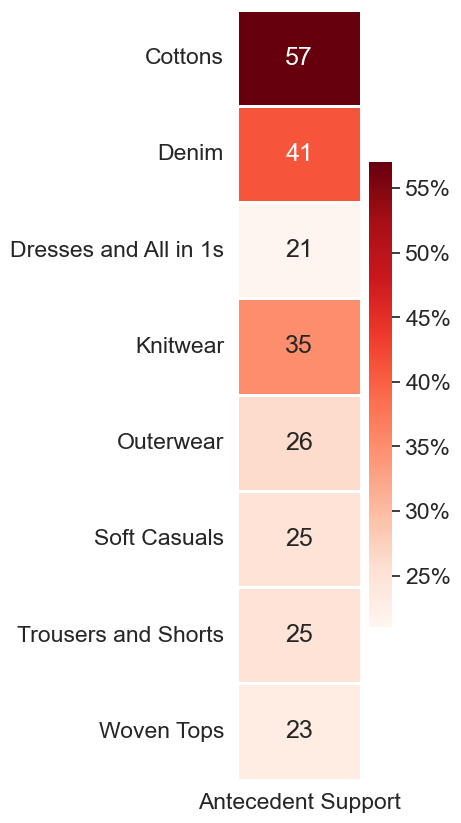

In [37]:
plt.figure(figsize = (2,10))
sns.heatmap(df_support_frv, cmap='Reds',linecolor='white',linewidths=1, annot = True, cbar_kws={'format': '%.0f%%'})

DO NOT RUN THIS NEXT LINE MORE THAN ONCE

To make the axes look nice for the heat map, I am applying this lambda rule so that the frozensets can be converted into normal strings.

Since the rules for antecedents and consequents were already created aboe, it is possible to apply a lambda function which applies a function to each element in the columns i.e cottons, woventops etc... 

The join(list(x)) part just converts to a list and since the characters are aleready sorted, one can just join it together
the comma and space is to join the elements into a single string.

The only problem is that it can only be run once because each time it is run, the rule is applied again which gives you commas and white space in between the letters (unless you clear all the outputs). This would be undesirable. Since this bit of code is only applied to the axis labels it doesn't really matter.

In [9]:
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

Now to turn this data into a useful visualisation. 

Converting the dataframe into a pivot table focused on confidence levels between the departments. Once I have the pivot tables, I will put the data into heat maps. The heat map in blue shows confidence, the latter shows leverage between departments.

The same is done but for leverage as I want to see association as well as probability.

In [10]:
frv_pivot_conf = pd.pivot(rules,values = 'confidence', index = 'antecedents', columns = 'consequents')

frv_pivot_lev = pd.pivot(rules,values = 'leverage', index = 'antecedents', columns = 'consequents')

<Axes: xlabel='consequents', ylabel='antecedents'>

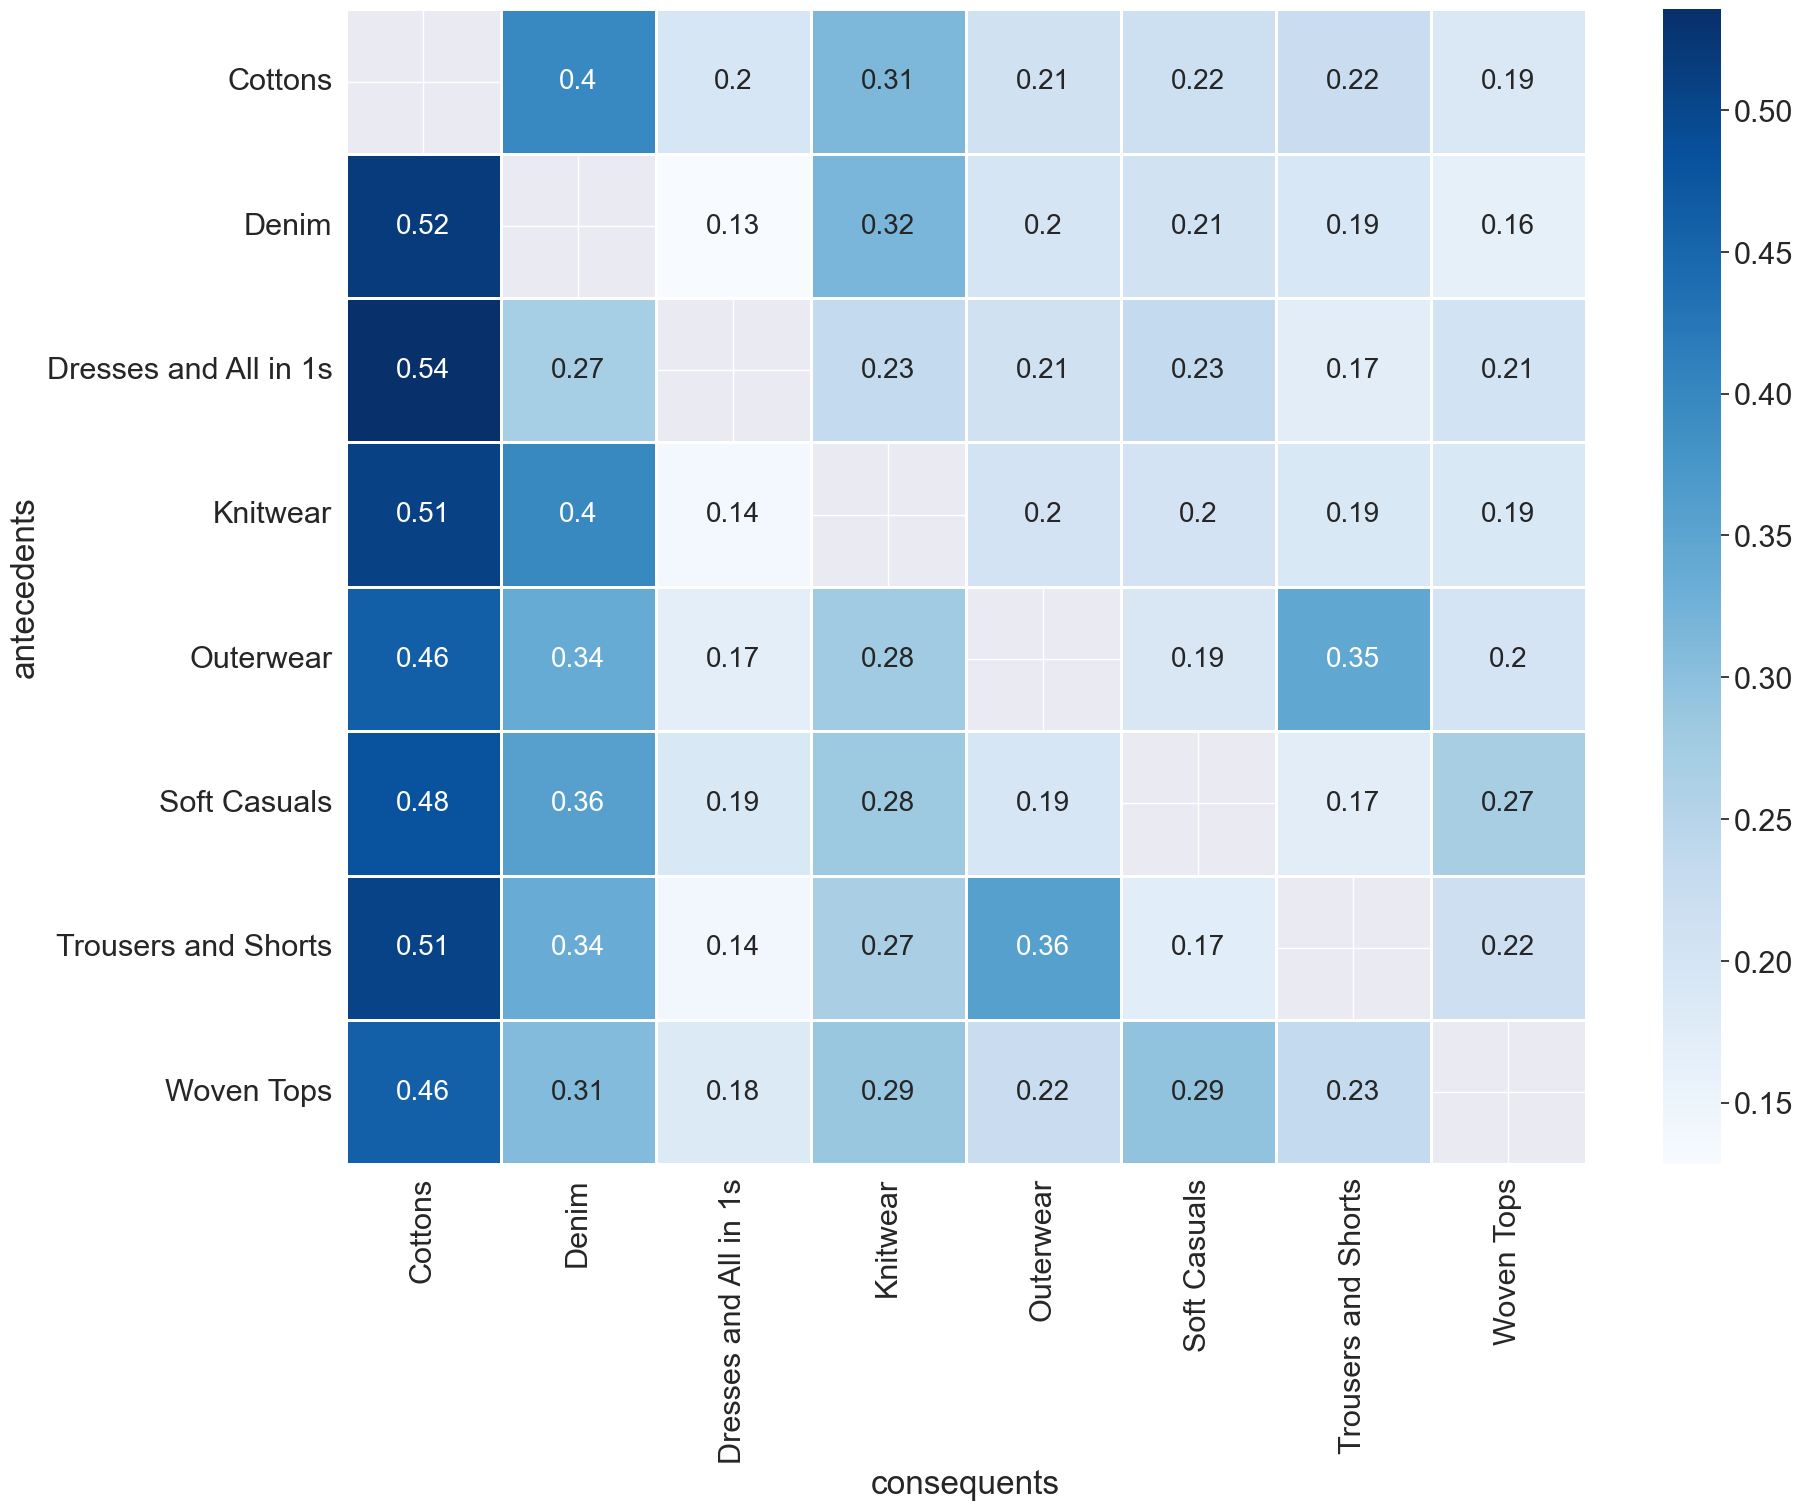

In [11]:
plt.figure(figsize = (20,15))
sns.set(font_scale=2)
sns.heatmap(frv_pivot_conf, cmap='Blues',linecolor='white',linewidths=1, annot = True, annot_kws = {'size': 20})

<Axes: xlabel='consequents', ylabel='antecedents'>

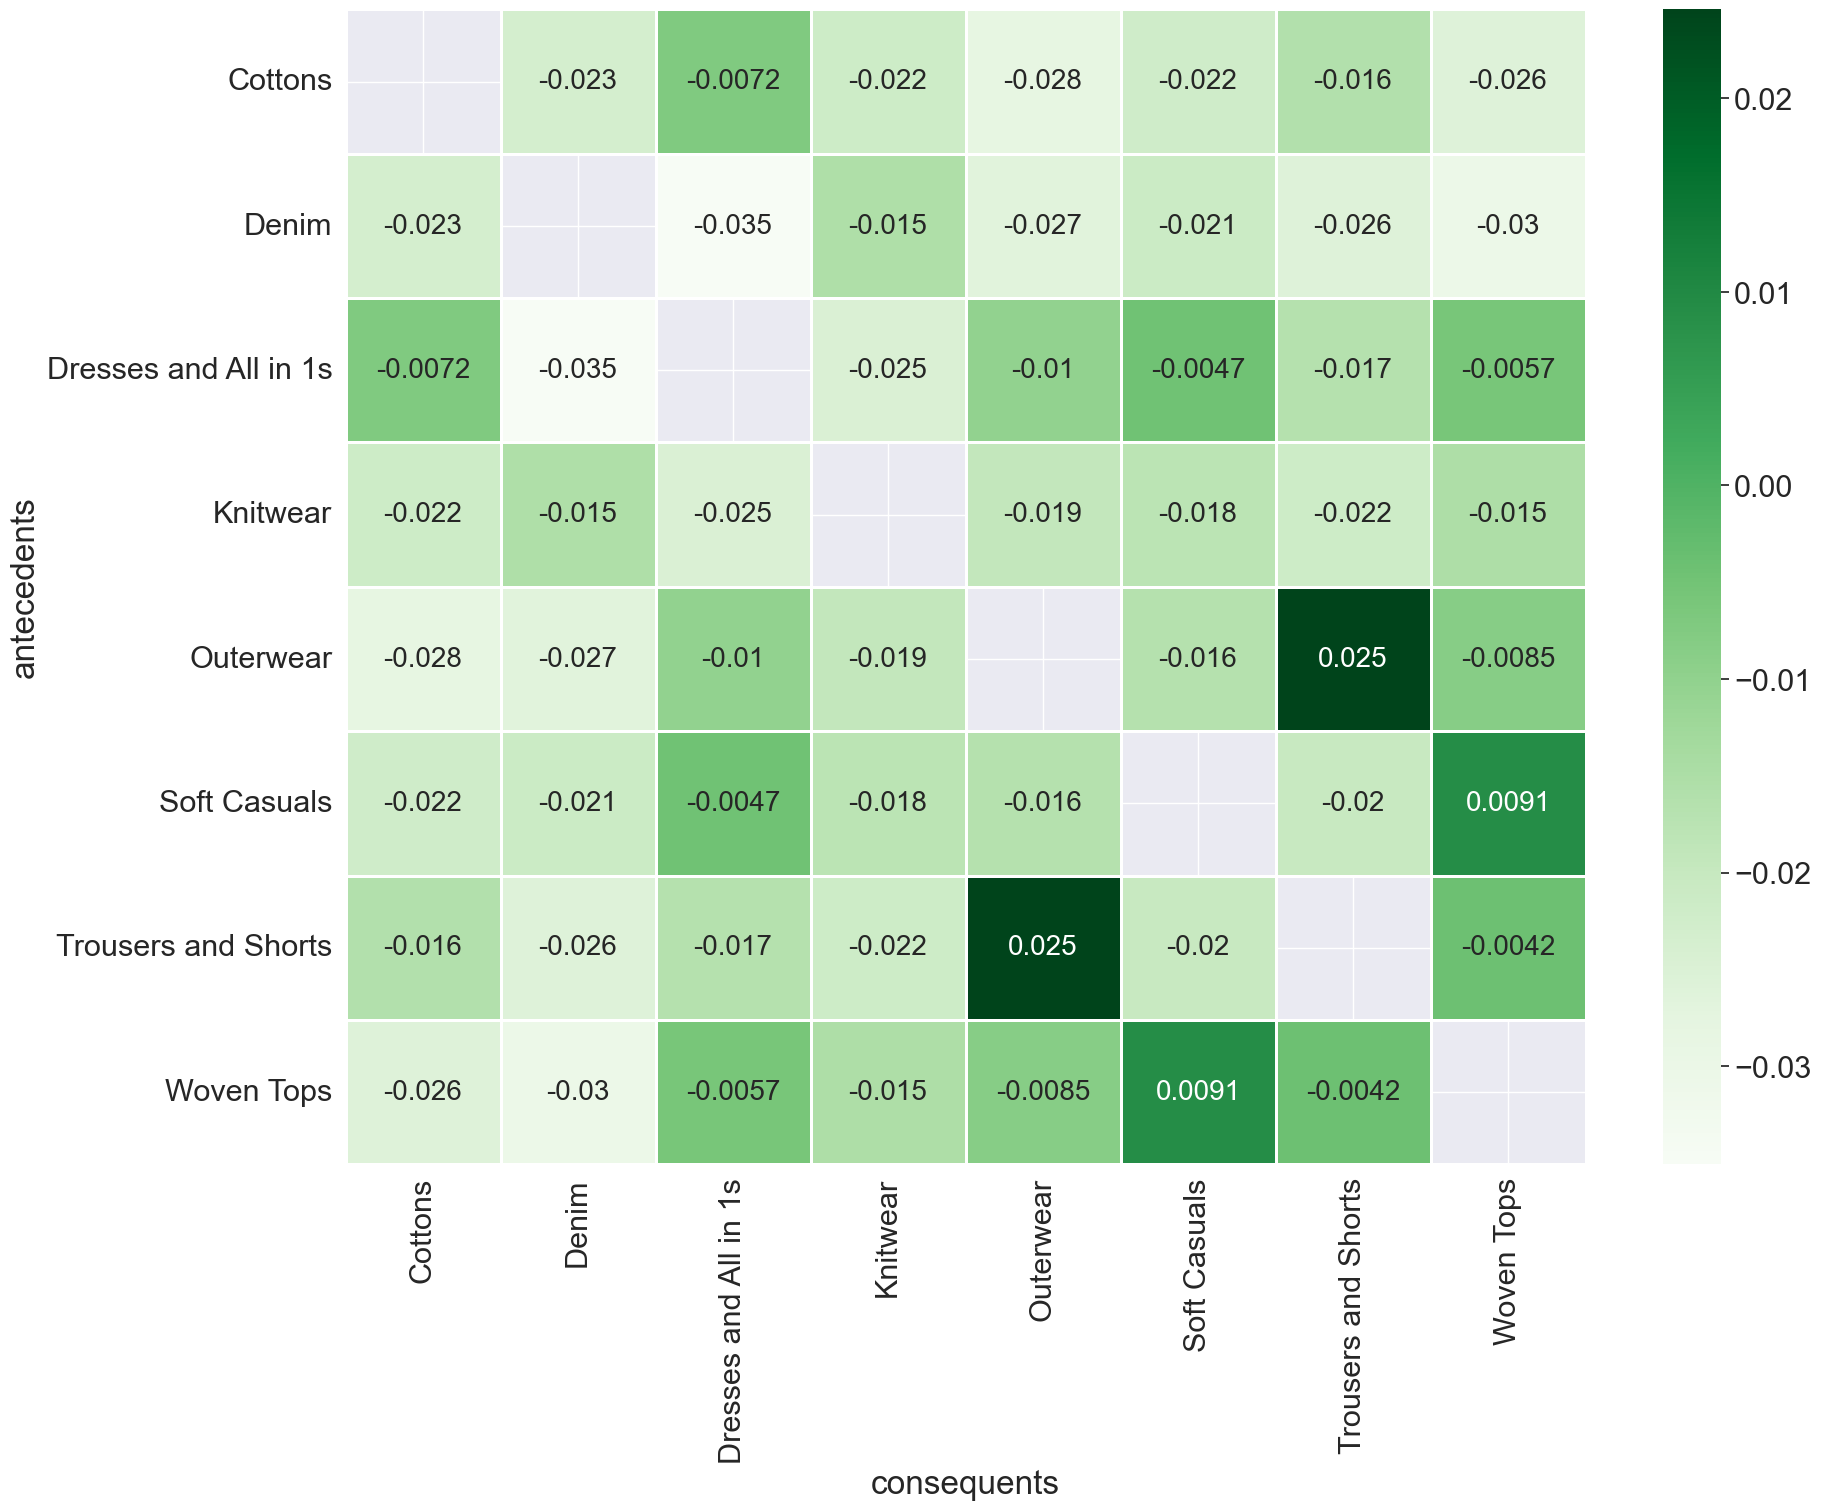

In [12]:
plt.figure(figsize = (20,15))
sns.set(font_scale=2)
sns.heatmap(frv_pivot_lev, cmap='Greens',linecolor='white',linewidths=1, annot = True, annot_kws = {'size': 20})

# Part 2: Conducting Basket Analysis on Stores with Smart Fitting Rooms (Sales)

This analysis is identical to Part 1 except I am looking at all sales of stores with smart fitting rooms regardless of whether the item purchased was tried on in the fitting room or not. 

In [13]:
df_sales = pd.read_csv('Crave Basket Sales.csv')
df_sales.head()

,MERCH_YR_WK,CAL_DT,LOCATION_ID,LOCATION_DESCR,ORDER_ID,DEPT_DESCR,SALE_QUANTITY,SALE_VALUE
0,202341,08/10/2023,829,STOKE FESTIVAL PARK,1045443,Cottons,1,34.2
1,202341,08/10/2023,829,STOKE FESTIVAL PARK,1045443,Outerwear,1,63.0
2,202341,08/10/2023,403,PORTSMOUTH,1053469,Denim,1,38.0
3,202341,08/10/2023,403,PORTSMOUTH,1053469,Cottons,1,15.0
4,202341,08/10/2023,403,PORTSMOUTH,1055312,Footwear,1,59.5


In [14]:
#Applying the same steps as above. 
basket_sales = df_sales.groupby(['ORDER_ID','DEPT_DESCR'])['SALE_QUANTITY'].sum().unstack().reset_index().fillna(0)
basket_data_sales = basket_sales.set_index(['ORDER_ID'])
basket_sets_sales = basket_data_sales.applymap(encode_units)
frequent_itemsets_sales = apriori(basket_sets_sales, min_support=0.01,use_colnames=True, max_len = 2)
rules_sales = association_rules(frequent_itemsets_sales, metric="lift", min_threshold=0)

C:\Users\rtcm\AppData\Local\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [15]:
#This converts the frozensets to strings (Should only run once)
rules_sales['antecedents'] = rules_sales['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_sales['consequents'] = rules_sales['consequents'].apply(lambda x: ', '.join(list(x)))

In [38]:
#And doing the same visuals

df_cs = pd.DataFrame({"Antecedent Support": [49, 31, 8,18,13,29,21,17,15,17,15]},
                  index=["Cottons", "Denim", "Dresses and All in 1s", "Footwear", "Handbags", "Knitwear", "Outerwear", "Soft Casuals", "Trousers and Shorts","WW DCK Jewellery", "Woven Tops"])

<Axes: >

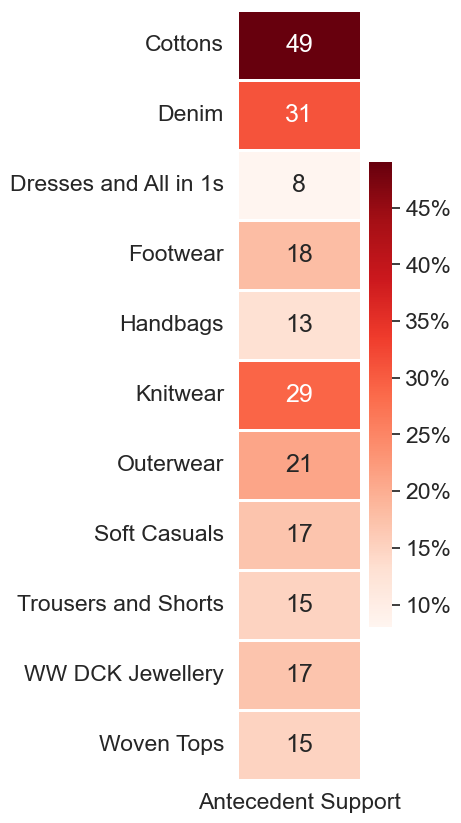

In [39]:
plt.figure(figsize = (2,10))
sns.heatmap(df_cs, cmap='Reds',linecolor='white',linewidths=1, annot = True,cbar_kws={'format': '%.0f%%'})

In [18]:
crave_sales_pivot_conf = pd.pivot(rules_sales, values = 'confidence', index = 'antecedents', columns = 'consequents') 
crave_sales_pivot_lev = pd.pivot(rules_sales, values = 'leverage', index = 'antecedents', columns = 'consequents')

<Axes: xlabel='consequents', ylabel='antecedents'>

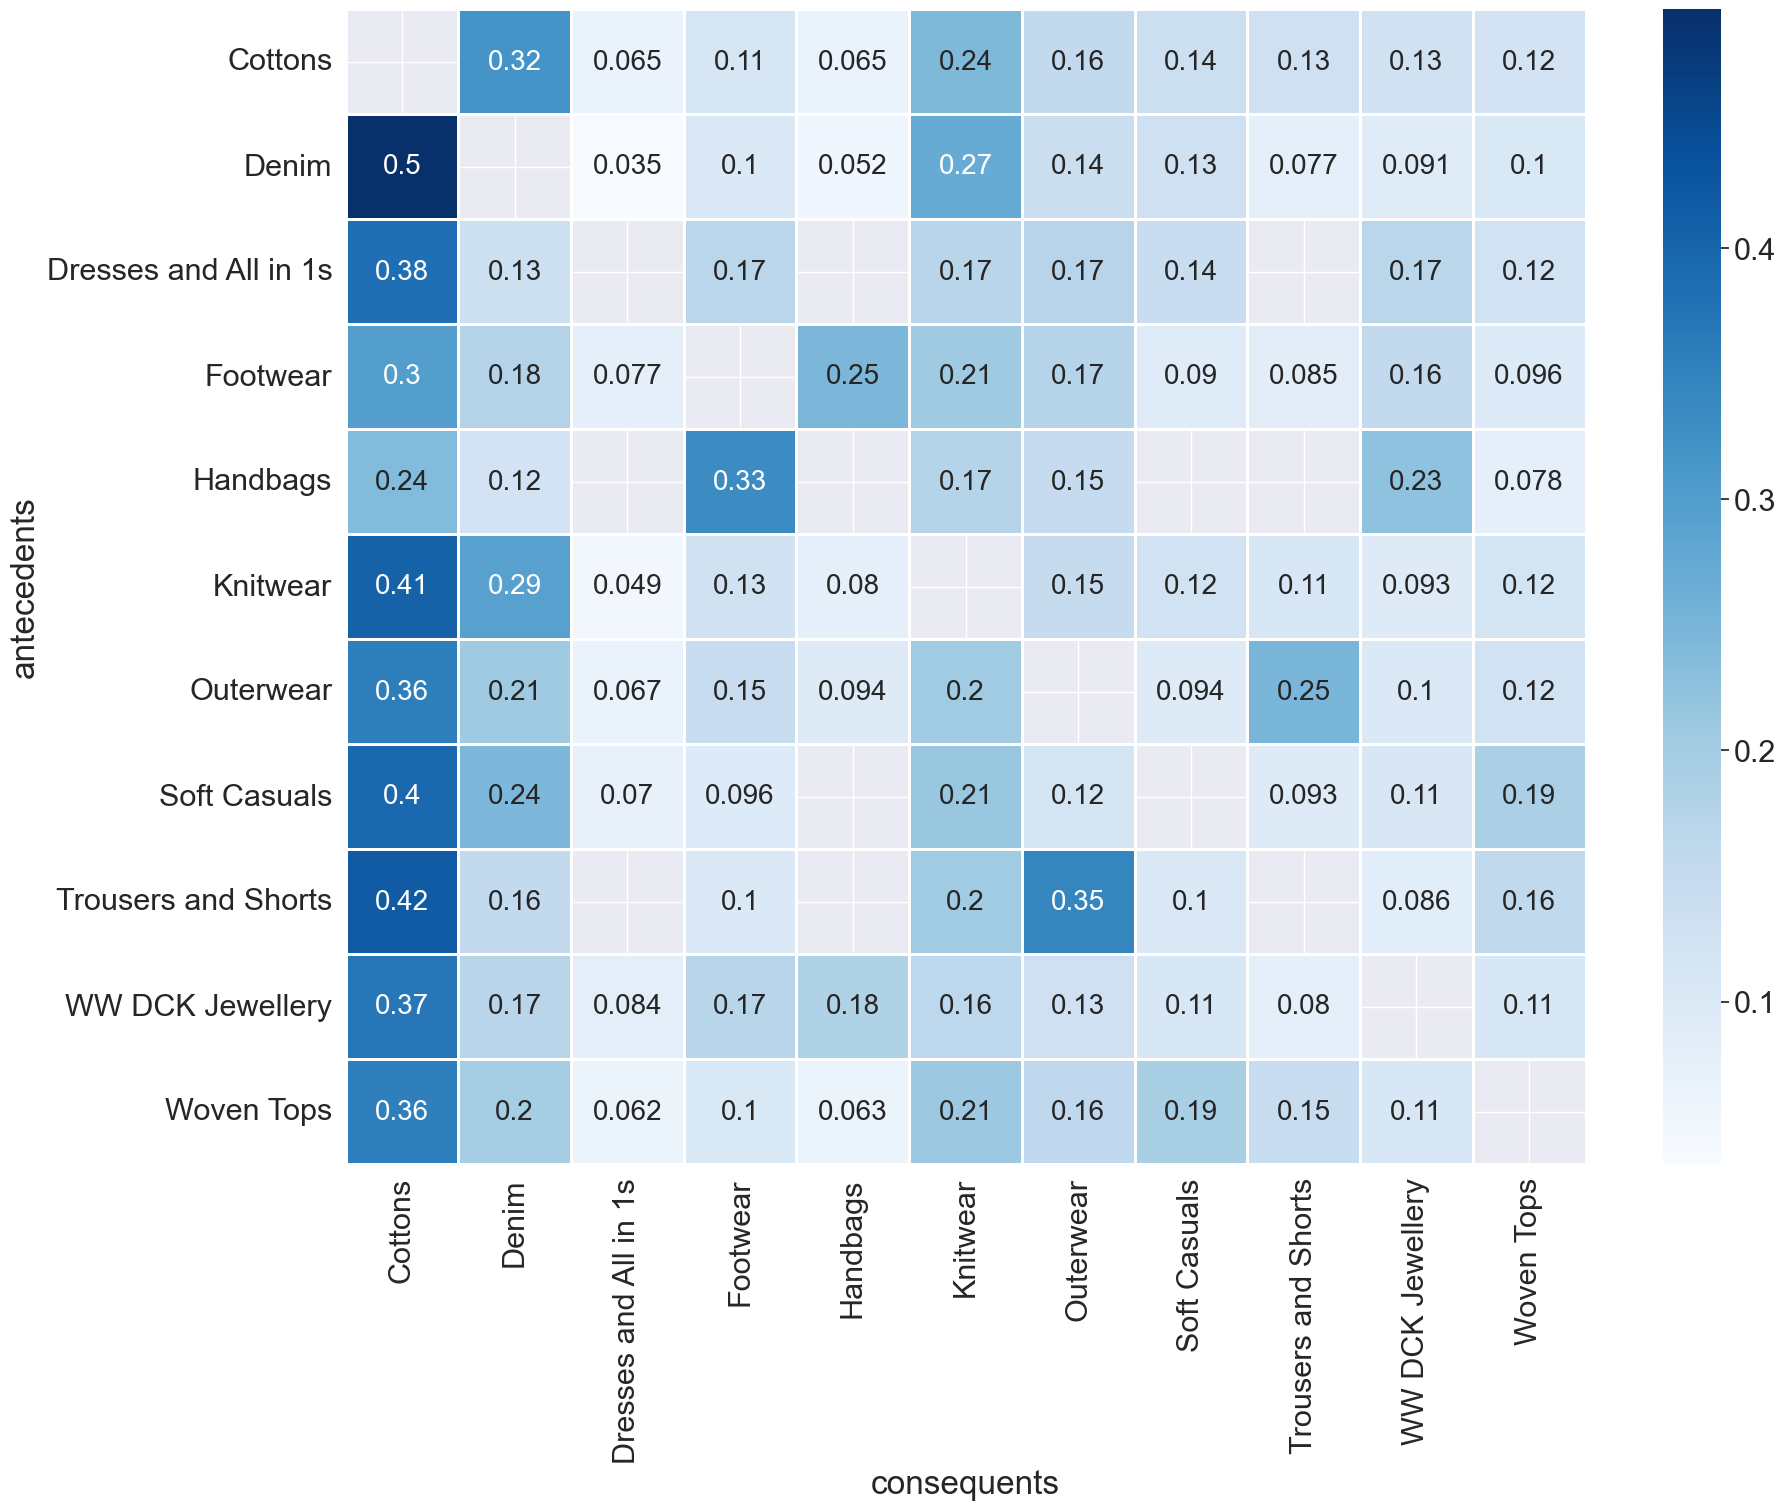

In [19]:
plt.figure(figsize = (20,15))
sns.set(font_scale=2)
sns.heatmap(crave_sales_pivot_conf, cmap='Blues',linecolor='white',linewidths=1, annot = True, annot_kws = {'size': 20})

<Axes: xlabel='consequents', ylabel='antecedents'>

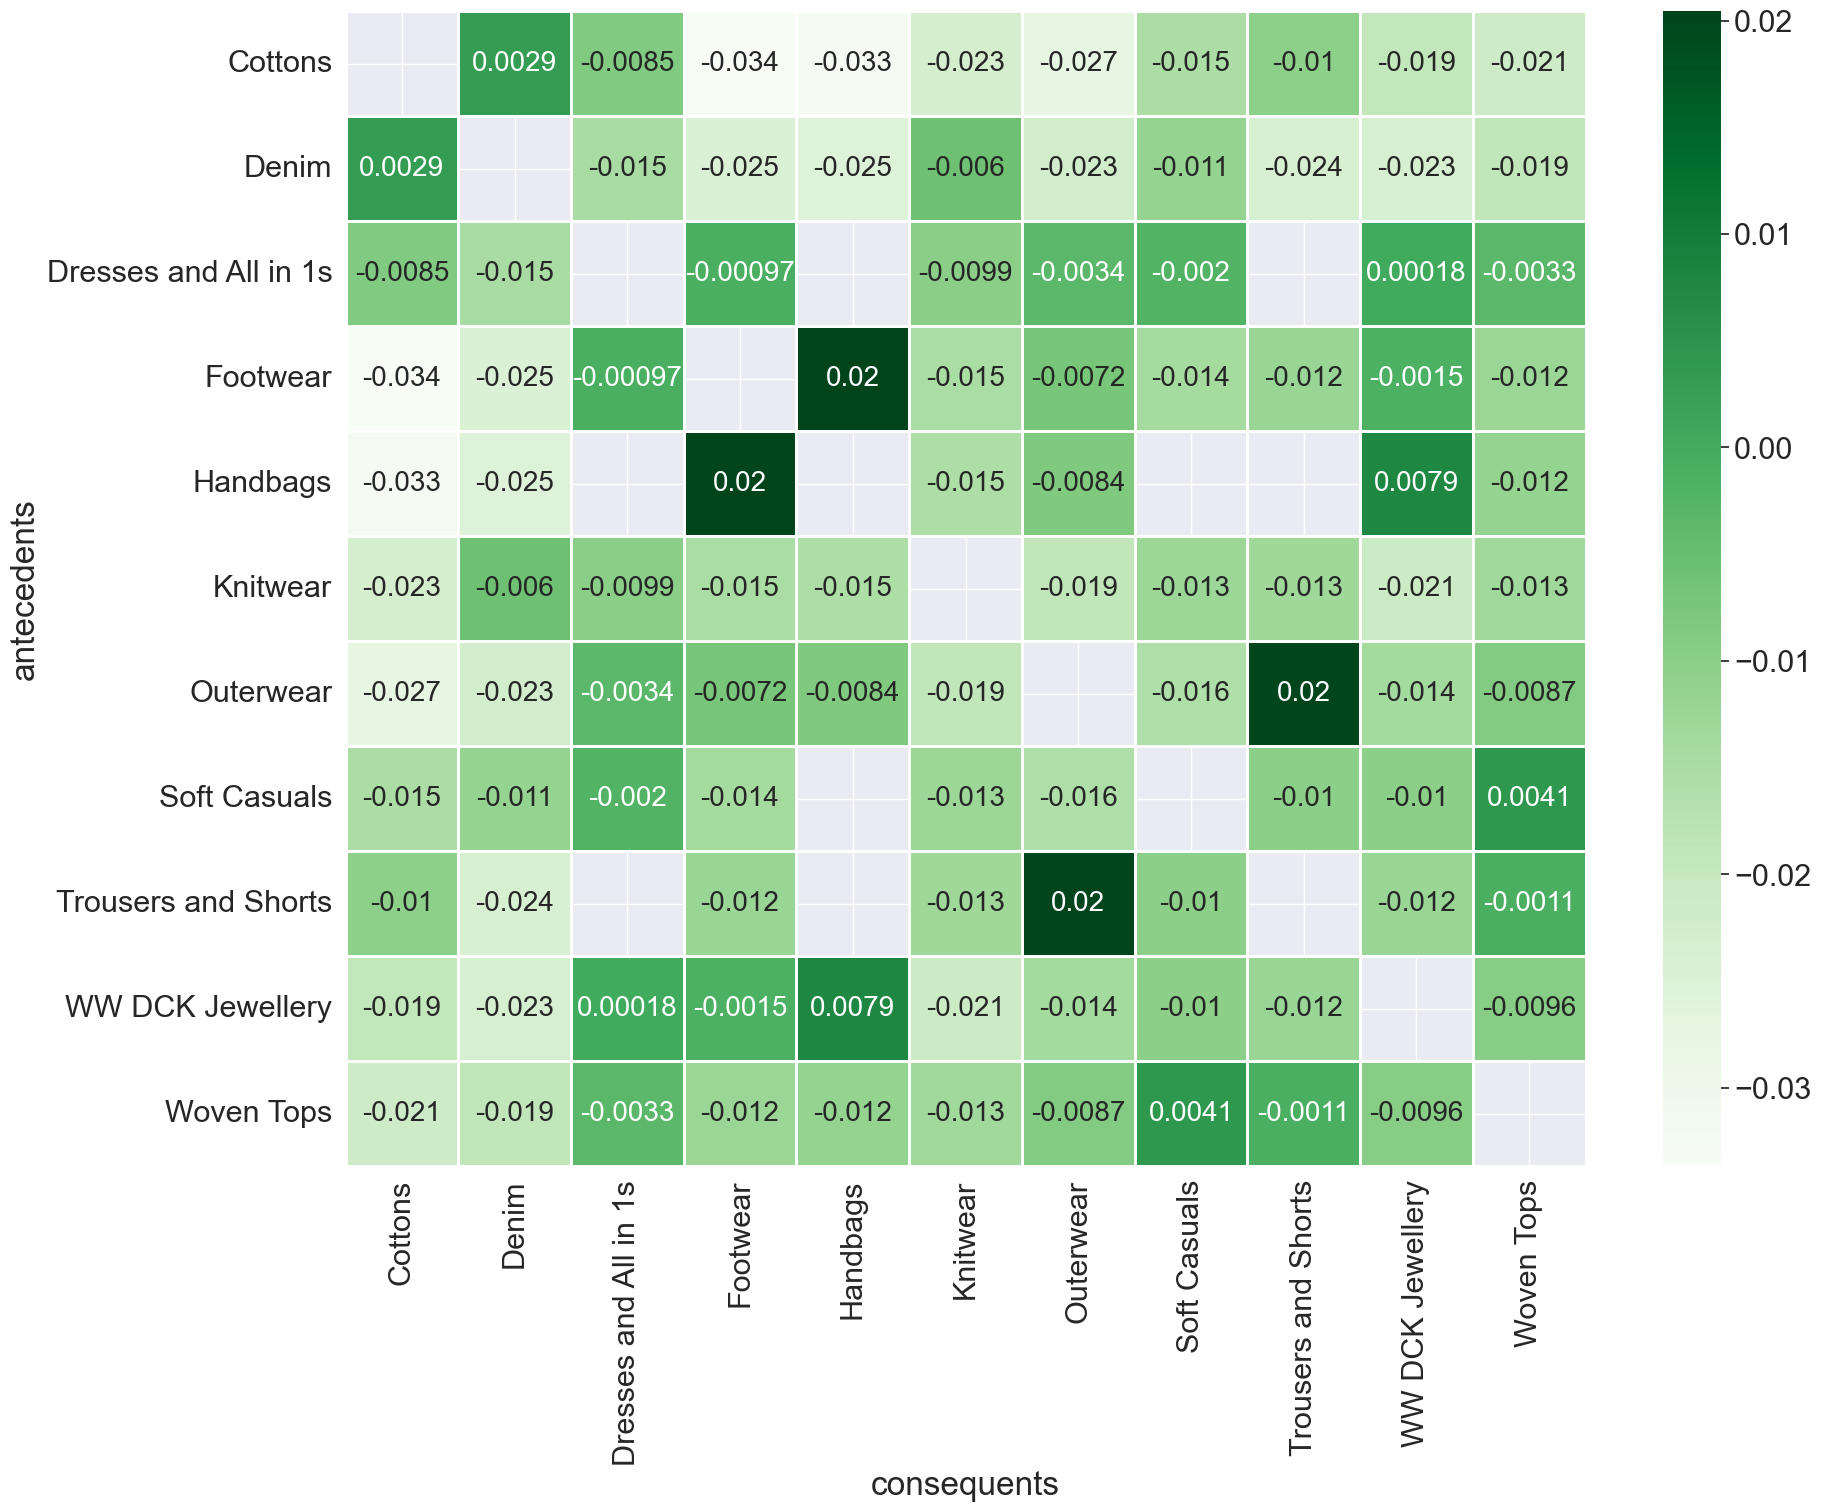

In [20]:
plt.figure(figsize = (20,15))
sns.set(font_scale=2)
sns.heatmap(crave_sales_pivot_lev, cmap='Greens',linecolor='white',linewidths=1, annot = True, annot_kws = {'size': 20})

# Part 3: Conducting Basket Analysis on Stores without Smart Fitting Rooms (Sales)

Lastly, repeating the above analysis but for all Non Crave Stores and their sales. 

In [21]:
df_nc = pd.read_csv('Non Crave Basket Sales.csv')
df_nc.head()

,MERCH_YR_WK,CAL_DT,LOCATION_ID,LOCATION_DESCR,ORDER_ID,DEPT_DESCR,SALE_QUANTITY,SALE_VALUE
0,202341,08/10/2023,250,DUBLIN DUNDRUM,1015323,Knitwear,2,36.0
1,202341,08/10/2023,250,DUBLIN DUNDRUM,1015323,Trousers and Shorts,1,14.0
2,202341,08/10/2023,232,GLASGOW FORT,1017138,Soft Casuals,1,40.0
3,202341,08/10/2023,232,GLASGOW FORT,1017138,Cottons,1,20.0
4,202341,08/10/2023,996,INVERNESS SHOPPING PARK,1017537,Cottons,1,7.0


In [22]:
basket_nc_sales = df_nc.groupby(['ORDER_ID','DEPT_DESCR'])['SALE_QUANTITY'].sum().unstack().reset_index().fillna(0)
basket_data_nc_sales = basket_nc_sales.set_index(['ORDER_ID'])
basket_sets_nc_sales = basket_data_nc_sales.applymap(encode_units)
frequent_itemsets_nc = apriori(basket_sets_nc_sales, min_support=0.01,use_colnames=True, max_len = 2)
rules_nc = association_rules(frequent_itemsets_nc, metric="lift", min_threshold=0)

C:\Users\rtcm\AppData\Local\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [23]:
#This converts the frozensets to strings (Should only run once)
rules_nc['antecedents'] = rules_nc['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_nc['consequents'] = rules_nc['consequents'].apply(lambda x: ', '.join(list(x)))

Trying to turn these into a pivot

In [40]:
df_nc = pd.DataFrame({"Antecedent Support": [52,33,8,19,13,29,21,17,15,23,19]},
                  index=["Cottons", "Denim", "Dresses and All in 1s", "Footwear", "Handbags", "Knitwear", "Outerwear", "Soft Casuals", "Trousers and Shorts","WW DCK Jewellery", "Woven Tops"])

<Axes: >

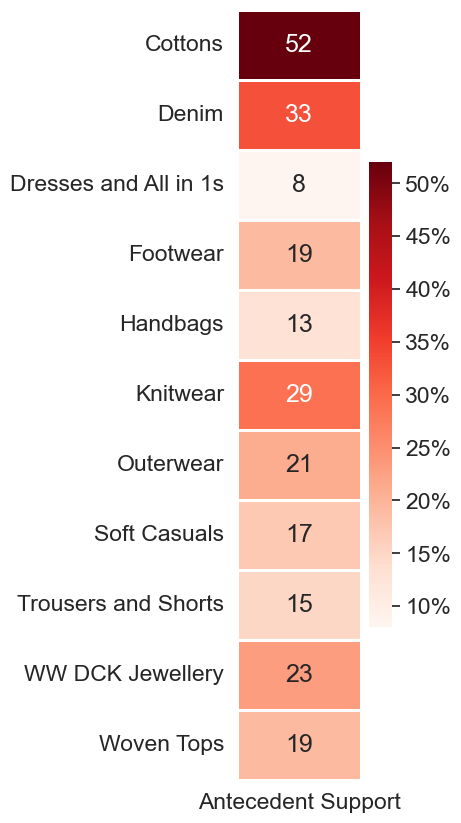

In [41]:
plt.figure(figsize = (2,10))
sns.heatmap(df_nc, cmap='Reds',linecolor='white',linewidths=1, annot = True,cbar_kws={'format': '%.0f%%'})

In [26]:
nc_sales_pivot_conf = pd.pivot(rules_nc, values = 'confidence', index = 'antecedents', columns = 'consequents') 
nc_sales_pivot_lev = pd.pivot(rules_nc, values = 'leverage', index = 'antecedents', columns = 'consequents') 

<Axes: xlabel='consequents', ylabel='antecedents'>

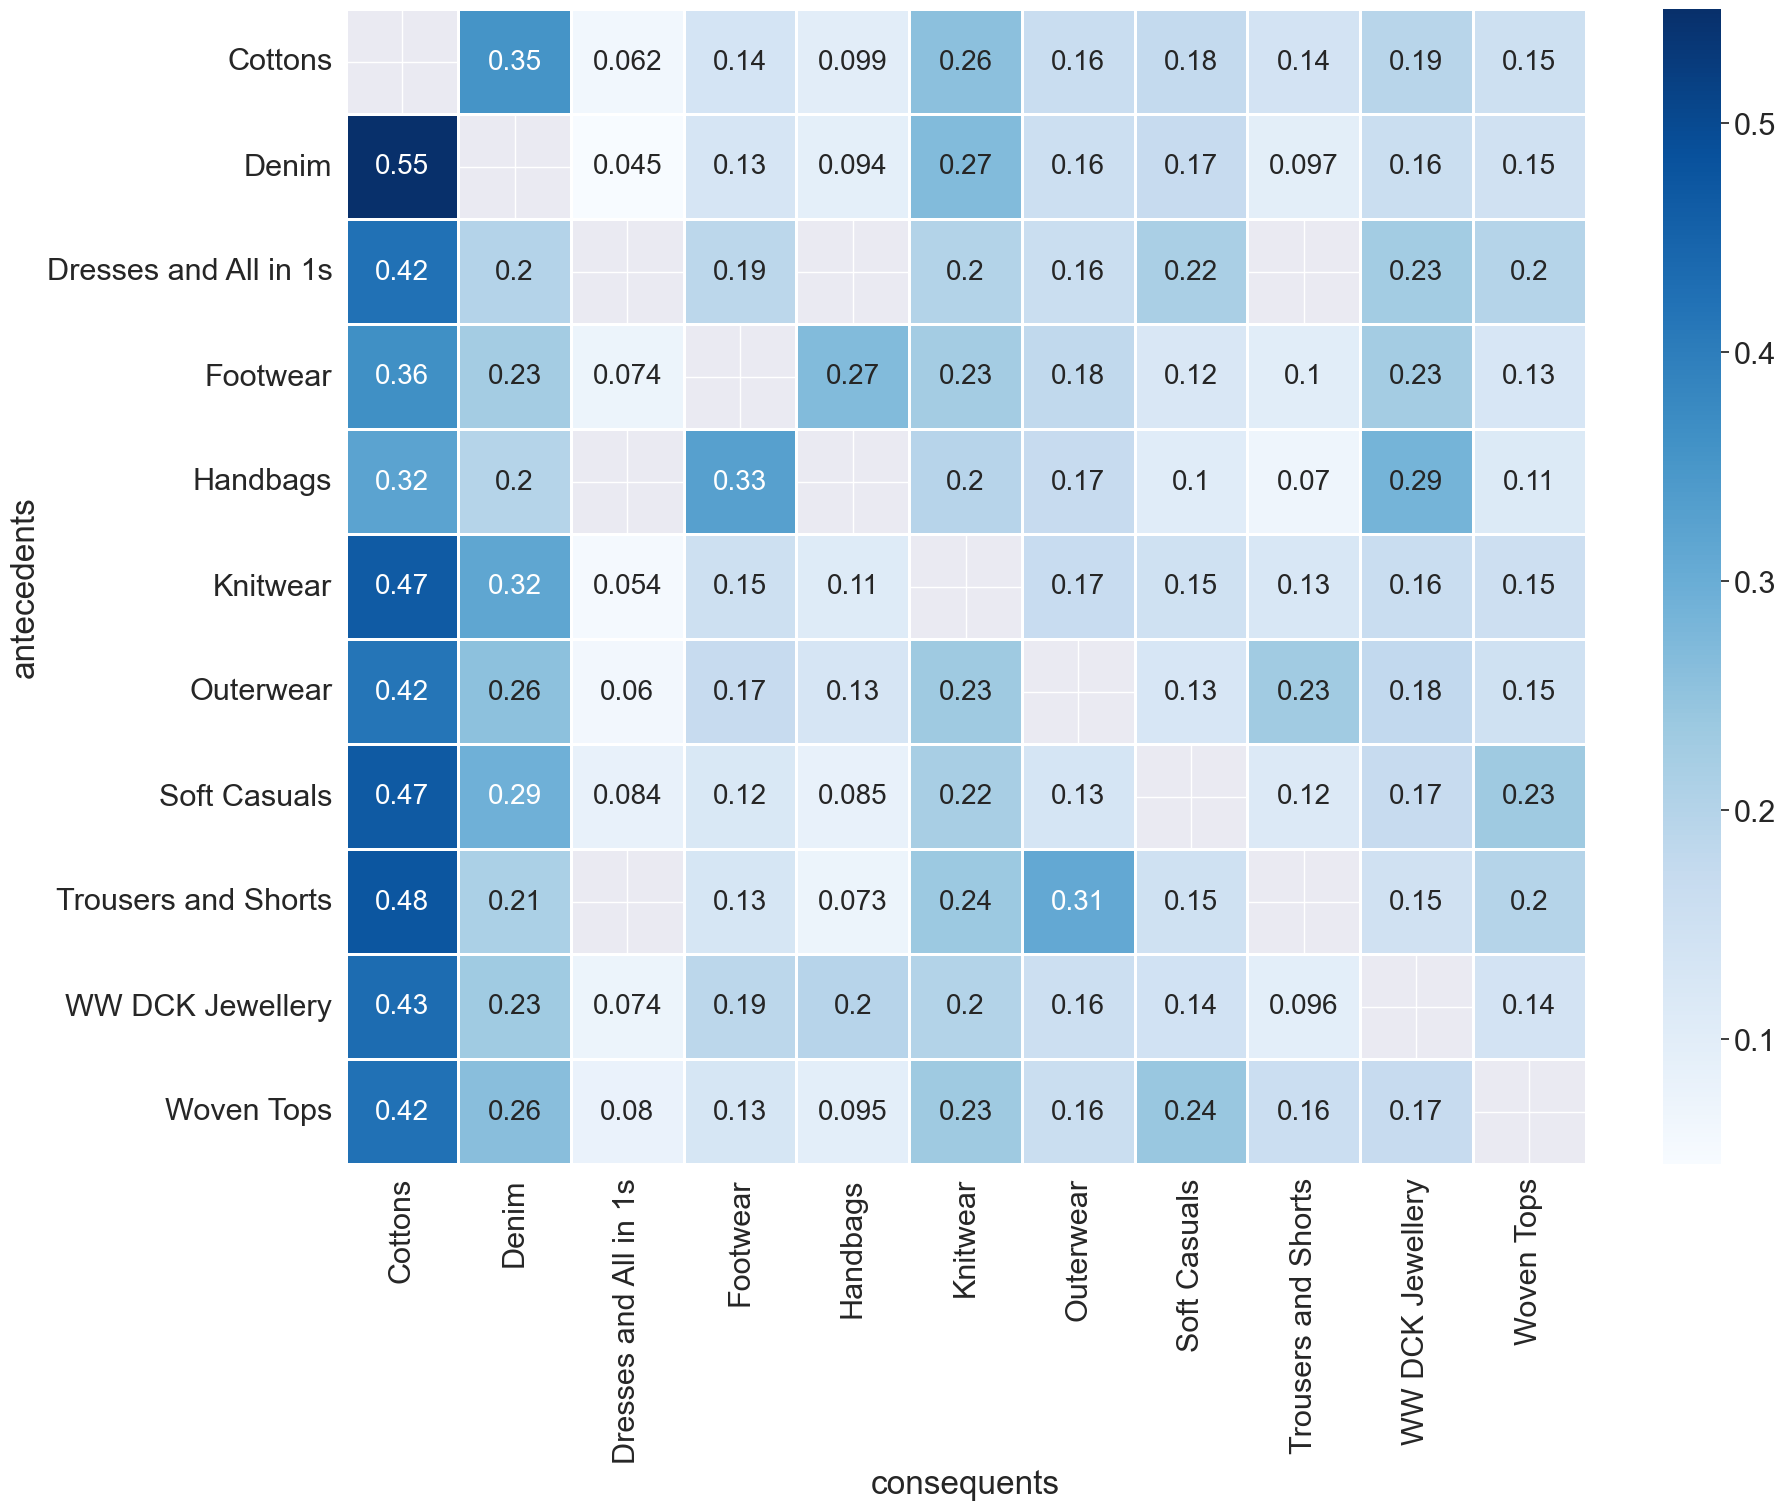

In [27]:
plt.figure(figsize = (20,15))
sns.set(font_scale=2)
sns.heatmap(nc_sales_pivot_conf, cmap='Blues',linecolor='white',linewidths=1, annot = True, annot_kws = {'size': 20})

<Axes: xlabel='consequents', ylabel='antecedents'>

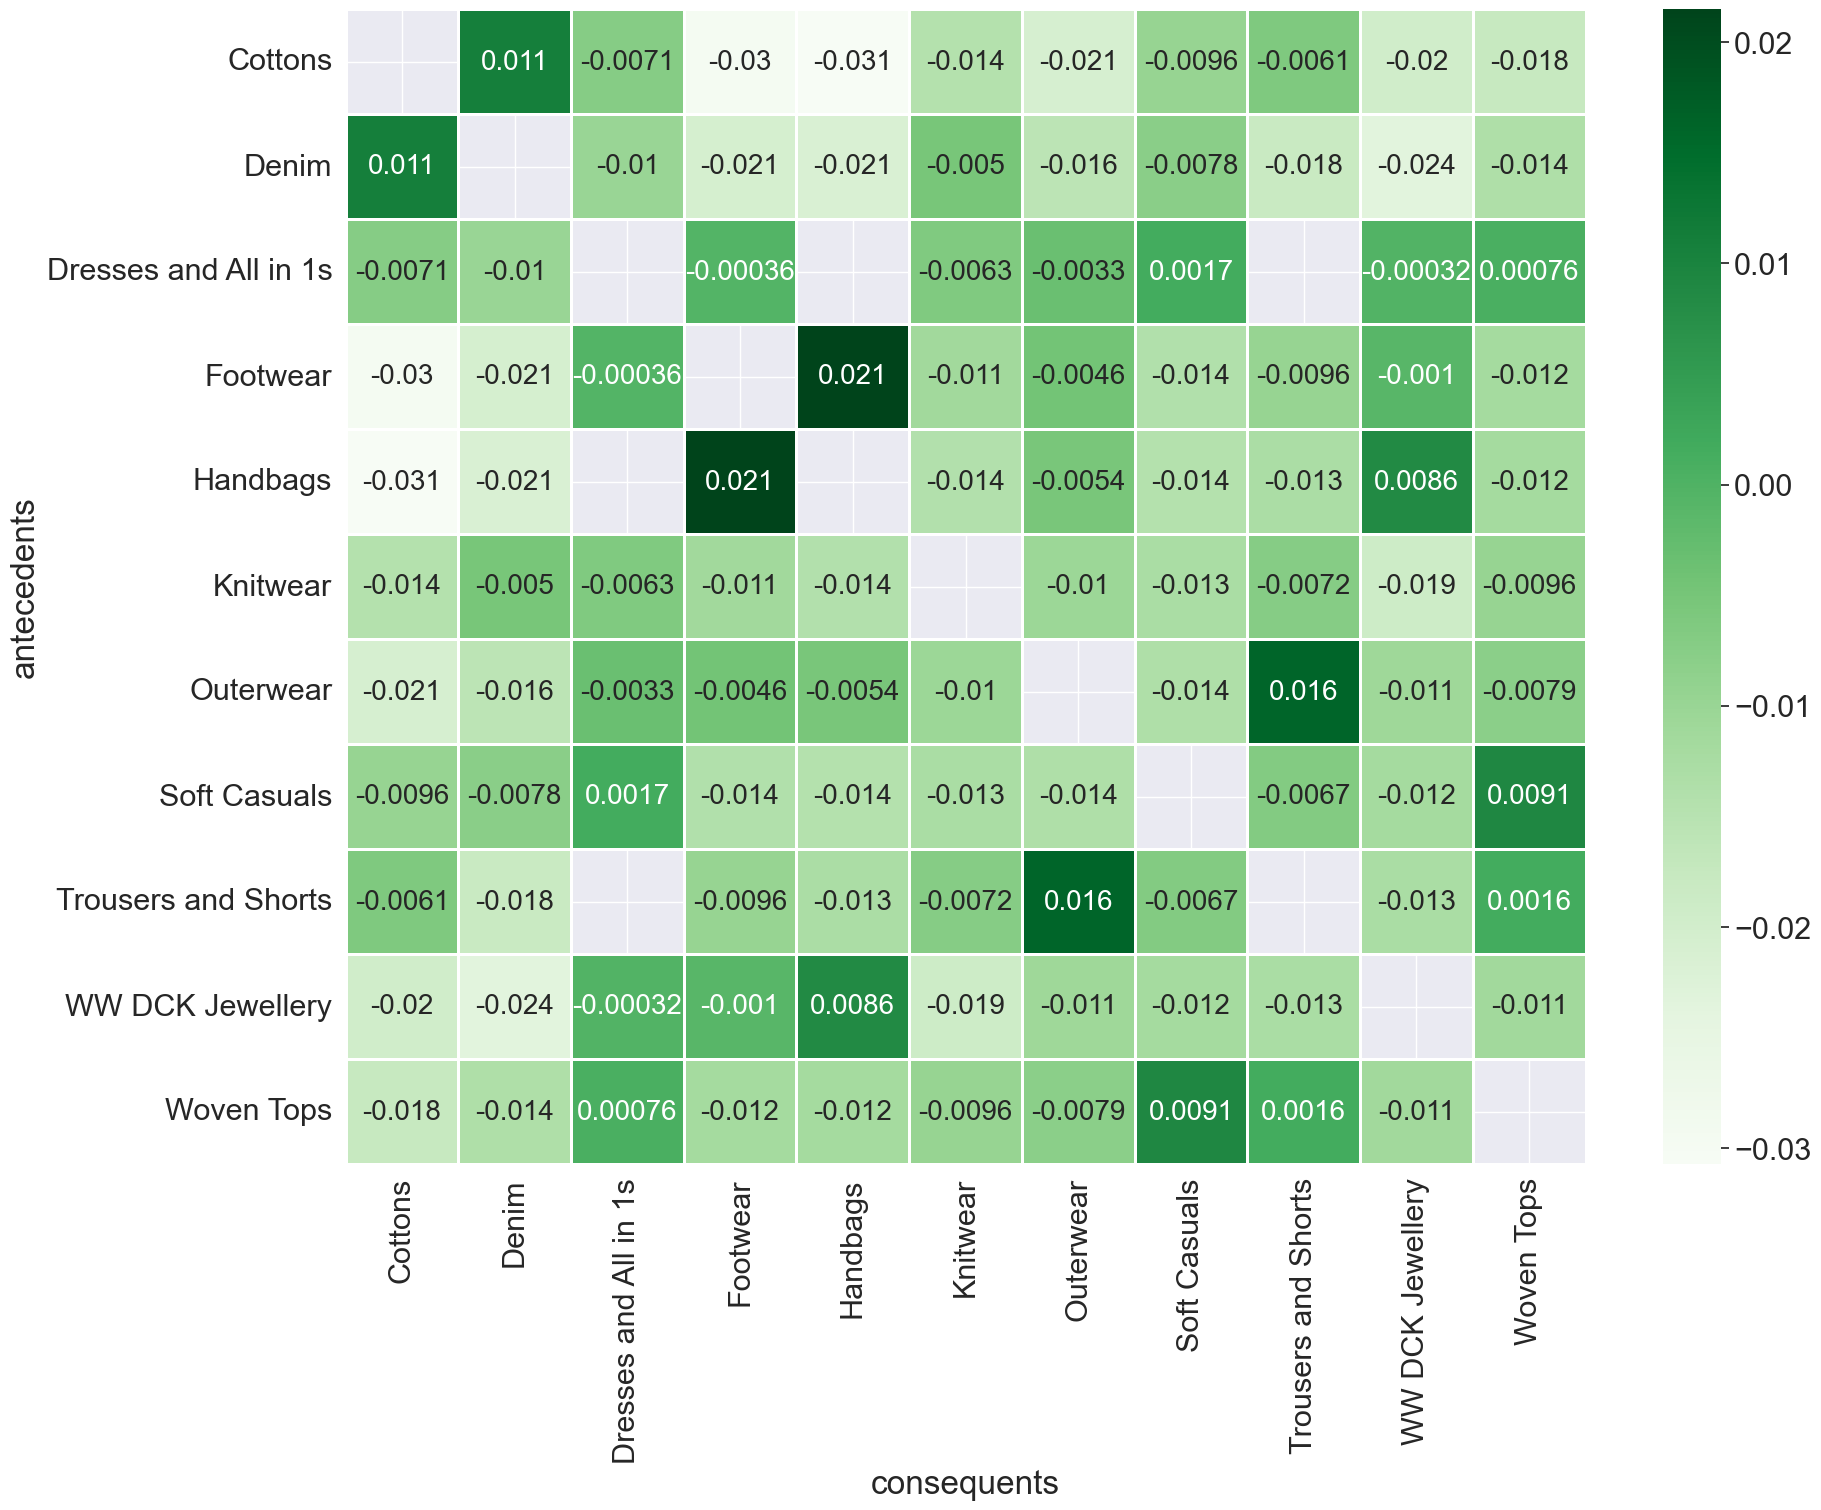

In [28]:
plt.figure(figsize = (20,15))
sns.set(font_scale=2)
sns.heatmap(nc_sales_pivot_lev, cmap='Greens',linecolor='white',linewidths=1, annot = True, annot_kws = {'size': 20})

_<u>Results<u>_:

From looking at the three analyses, here are the conclusions: 

1. During this time of the year, no matter whether the store had smart fitting room technology or not, the most common combination of departments was cottons and denim. 
2. This association is stronger in stores without smart fitting rooms than stores with smart fitting rooms. 
3. Outerwear and Trousers and Shorts were also a fairly strong combination across both types of stores, but this is due to seasonality. 
4. This combination was roughly the same in both types of stores but interesting the confidence is higher when the antecedent is trousers and shorts and the consequent is outerwear which implies those looking for something from the trousers and shorts departments are looking to buy a complete outfit, but that's not necessarily true the other way round. 
5. In terms of fitting room visits, the combination with the highest confidence level is Dresses and all in 1s with Cottons. 
6. Cottons is the most likely consequent i.e if a customer takes any item from another department into the fitting room, they are most likely to also take an item from the Cottons department as well. 


# Further Analysis

Analysis of the data at product level to try and see if I can identify if there are any specific combination of products which:

1. Are being taken into the fitting room.
2. Being sold together in smart fitting room stores.
3. Being sold together in non smart fitting room stores.

The analysis is more or less identical to the 3 analyses above, just without the heat maps. 

<u> Part 1: Fitting Room Visits <u>

In [4]:
df_prod = pd.read_csv('Crave Basket FRV Product.csv')
df_prod.head()

,TERRITORY,MARKET,LOCATION_ID,LOCATION_DESCR,CAL_DT,MERCH_YR_WK,UNIQUE_SHOPPER_ID,DEPT_DESCR,OPTION_DESCR,ITEM_QUANTITY,ITEM_PRICE
0,SOUTH,SOUTH EAST,22,KINGSTON,08/10/2023,202341,1263495,Knitwear,Grey - Marl Cosy Jumper Dress FL,1,45
1,SOUTH,SOUTH EAST,22,KINGSTON,08/10/2023,202341,1263495,Cottons,Grey - Dark SS Emb Grown On Slv Tee,1,30
2,SOUTH,SOUTH EAST,22,KINGSTON,08/10/2023,202341,1263495,Knitwear,Red Rib Mix Roll Neck Top FL,1,29
3,SOUTH,SOUTH EAST,22,KINGSTON,08/10/2023,202341,1263500,Knitwear,Red Rib Mix Roll Neck Top FL,2,58
4,SOUTH,SOUTH EAST,22,KINGSTON,08/10/2023,202341,1263500,Knitwear,Black Heatseal Bodyfit Top,1,40


In [5]:
#Applying the function to the dataframe

basket_prodfrv = df_prod.groupby(['UNIQUE_SHOPPER_ID','OPTION_DESCR'])['ITEM_QUANTITY'].sum().unstack().reset_index().fillna(0)
basket_data_prod = basket_prodfrv.set_index(['UNIQUE_SHOPPER_ID'])
basket_sets_prod = basket_data_prod.applymap(encode_units)

In [22]:
frequent_itemsets_frv = apriori(basket_sets_prod, min_support=0.005,use_colnames=True, max_len = 2)
rules_frv = association_rules(frequent_itemsets_frv, metric="lift", min_threshold=1)
rules_frv.head()

C:\Users\rtcm\AppData\Local\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Black Wide Leg Pleated Clean Trouser),(Black Button Front Clean Waistcoat),0.046460,0.034335,0.005909,0.127193,3.704448,0.004314,1.106390,0.765625
1,(Black Button Front Clean Waistcoat),(Black Wide Leg Pleated Clean Trouser),0.034335,0.046460,0.005909,0.172107,3.704448,0.004314,1.151768,0.756012
2,(Black Shawl Collar Tux Blazer),(Black Satin Stripe Straight Trouser),0.009068,0.024656,0.005196,0.573034,23.241016,0.004973,2.284358,0.965730
3,(Black Satin Stripe Straight Trouser),(Black Shawl Collar Tux Blazer),0.024656,0.009068,0.005196,0.210744,23.241016,0.004973,1.255527,0.981164
4,(Black Sparkle Button Front Waistcoat),(Black Sparkle Velvet Slim Trouser),0.027509,0.034947,0.016709,0.607407,17.381060,0.015748,2.458155,0.969126


<u> Part 2: Sales from Smart Fitting Room Stores <u>

In [12]:
df_prod_cs = pd.read_csv('Crave Basket Sales Product.csv')
df_prod_cs.head()

,MERCH_YR_WK,CAL_DT,LOCATION_ID,LOCATION_DESCR,ORDER_ID,DEPT_DESCR,OPTION_DESCR,SALE_QUANTITY,SALE_VALUE
0,202341,08/10/2023,829,STOKE FESTIVAL PARK,1045443,Outerwear,Cream Short City Wrap Coat,1,63.0
1,202341,08/10/2023,829,STOKE FESTIVAL PARK,1045443,Cottons,Black LS Ruched Drape Mini Dress,1,34.2
2,202341,08/10/2023,403,PORTSMOUTH,1053469,Cottons,Grey - Light SS Washed Paris Boyf Tee,1,15.0
3,202341,08/10/2023,403,PORTSMOUTH,1053469,Denim,Denim - Medium 90s Long Straight Mid Elton,1,38.0
4,202341,08/10/2023,403,PORTSMOUTH,1115453,Cottons,Black LS Ruched Drape Top,1,28.0


In [21]:
basket_prod_cs = df_prod_cs.groupby(['ORDER_ID','OPTION_DESCR'])['SALE_QUANTITY'].sum().unstack().reset_index().fillna(0)
basket_data_prod_cs = basket_prod_cs.set_index(['ORDER_ID'])
basket_sets_prod_cs = basket_data_prod_cs.applymap(encode_units)
frequent_itemsets_cs = apriori(basket_sets_prod_cs, min_support=0.005,use_colnames=True, max_len = 2)
rules_cs = association_rules(frequent_itemsets_cs, metric="lift", min_threshold=1)
rules_cs.head()

C:\Users\rtcm\AppData\Local\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Beige Pinstripe Roll Sleeve Blazer),(Beige Pinstripe Straight Trouser),0.008575,0.010914,0.006431,0.750000,68.718750,0.006338,3.956344,0.993972
1,(Beige Pinstripe Straight Trouser),(Beige Pinstripe Roll Sleeve Blazer),0.010914,0.008575,0.006431,0.589286,68.718750,0.006338,2.413904,0.996322
2,(Black Wide Leg Pleated Clean Trouser),(Black Button Front Clean Waistcoat),0.033327,0.022023,0.005067,0.152047,6.904000,0.004333,1.153338,0.884639
3,(Black Button Front Clean Waistcoat),(Black Wide Leg Pleated Clean Trouser),0.022023,0.033327,0.005067,0.230088,6.904000,0.004333,1.255564,0.874414
4,(Black Shawl Collar Tux Blazer),(Black Satin Stripe Straight Trouser),0.007991,0.013448,0.005262,0.658537,48.970308,0.005155,2.889189,0.987470


<u> Part 3: Sales from Non Smart Fitting Room Stores <u>

In [18]:
df_prod_ncs = pd.read_csv('Non Crave Basket Sales Product.csv')
df_prod_ncs.head()

,MERCH_YR_WK,CAL_DT,LOCATION_ID,LOCATION_DESCR,ORDER_ID,DEPT_DESCR,OPTION_DESCR,SALE_QUANTITY,SALE_VALUE
0,202341,08/10/2023,250,DUBLIN DUNDRUM,1015323,Knitwear,Black Crochet Button Top SP,1,12.0
1,202341,08/10/2023,250,DUBLIN DUNDRUM,1015323,Trousers and Shorts,White Cigarette Trouser FL,1,14.0
2,202341,08/10/2023,250,DUBLIN DUNDRUM,1015323,Knitwear,Gold Crochet Belt Top,1,24.0
3,202341,08/10/2023,104,DONCASTER,1018505,Cottons,Black SL Notch Mini Rib Dress FL,1,5.0
4,202341,08/10/2023,104,DONCASTER,1018505,Cottons,White SL Scoop Neck Tank FL,1,9.0


In [20]:
basket_prod_ncs = df_prod_ncs.groupby(['ORDER_ID','OPTION_DESCR'])['SALE_QUANTITY'].sum().unstack().reset_index().fillna(0)
basket_data_prod_ncs = basket_prod_ncs.set_index(['ORDER_ID'])
basket_sets_prod_ncs = basket_data_prod_ncs.applymap(encode_units)
frequent_itemsets_ncs = apriori(basket_sets_prod_ncs, min_support=0.005,use_colnames=True, max_len = 2)
rules_ncs = association_rules(frequent_itemsets_ncs, metric="lift", min_threshold=1)
rules_ncs.head()

C:\Users\rtcm\AppData\Local\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Black Sparkle Button Front Waistcoat),(Black Sparkle Velvet Slim Trouser),0.012242,0.021054,0.007641,0.624146,29.645685,0.007383,2.604591,0.978244
1,(Black Sparkle Velvet Slim Trouser),(Black Sparkle Button Front Waistcoat),0.021054,0.012242,0.007641,0.362914,29.645685,0.007383,1.550431,0.987049
2,(Black Sparkle Velvet Tux Blazer),(Black Sparkle Velvet Slim Trouser),0.014640,0.021054,0.012158,0.830476,39.445969,0.011850,5.774684,0.989130
3,(Black Sparkle Velvet Slim Trouser),(Black Sparkle Velvet Tux Blazer),0.021054,0.014640,0.012158,0.577483,39.445969,0.011850,2.332122,0.995610
4,(Grey - Marl Roll Sleeve Relaxed SB Blazer),(Grey Straight Leg Trouser),0.015978,0.016313,0.009565,0.598604,36.694927,0.009304,2.450664,0.988544


The analysis shows that regardless of the type of stores, customers buy complete outfits.